In [1]:
import os
import pywt
import torch
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from quantus.metrics import Complexity
from scipy.fftpack import fft, fftfreq
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_5.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [4]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_3"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)


(10000, 1, 16)
(10000,)


In [5]:
attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

# prediction
for batch in test_loader:
    # get data
    x, y = batch
    x = x.to(device)
    output = model(x)

    predictions.append(output)
    labels.append(y)

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

In [6]:
correct = 0
for i in range(len(predictions)):
    if predictions[i].argmax() == labels[i]:
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")

Accuracy: 1.0


In [7]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [8]:
# evaluate wavelet
fs = 16
batch_size = 128
wavelet = 'db'
w_len = 1
normalized = True
level = pywt.dwt_max_level(fs, 'db1')
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_db1_4_128


In [ ]:
# set the seed for reproducibility
set_seed(42)

# compute the attributions
method = 'wavelet'

args = SimpleNamespace(wavelet=wavelet, len_w=w_len, level=level, sample_freq=fs)
print(args.wavelet)
print(args.len_w)
print(args.level)
print(args.sample_freq)

attrs, masks = compute_attribution(method = method, model = model, test_loader= test_loader, args = args, device=device, normalize=normalized)

db
1
4
16
Batch 0 of 79
Sample 0 of 128
Epoch 0: Loss=1.7463, Target=1.2963, Reg=0.4500
Epoch 10: Loss=0.8630, Target=0.4676, Reg=0.3954
Epoch 20: Loss=0.6670, Target=0.3139, Reg=0.3530
Epoch 30: Loss=0.6178, Target=0.3133, Reg=0.3044
Epoch 40: Loss=0.5656, Target=0.3133, Reg=0.2523
Epoch 50: Loss=0.5114, Target=0.3133, Reg=0.1981
Epoch 60: Loss=0.4905, Target=0.3133, Reg=0.1772
Epoch 70: Loss=0.4703, Target=0.3133, Reg=0.1570
Epoch 80: Loss=0.4502, Target=0.3133, Reg=0.1369
Epoch 90: Loss=0.4306, Target=0.3133, Reg=0.1173
Epoch 100: Loss=0.4131, Target=0.3133, Reg=0.0997
Epoch 110: Loss=0.3960, Target=0.3133, Reg=0.0827
Epoch 120: Loss=0.3834, Target=0.3134, Reg=0.0700
Epoch 130: Loss=0.3703, Target=0.3134, Reg=0.0569
Epoch 140: Loss=0.3615, Target=0.3134, Reg=0.0481
Epoch 150: Loss=0.3559, Target=0.3134, Reg=0.0425
Epoch 160: Loss=0.3509, Target=0.3135, Reg=0.0374
Epoch 170: Loss=0.3458, Target=0.3135, Reg=0.0322
Epoch 180: Loss=0.3405, Target=0.3136, Reg=0.0269
Epoch 190: Loss=0.335

In [11]:
attributions[key_] = attrs
attributions[f'filtermasks_{key_}'] = masks

In [12]:
print(attributions.keys())
print(key_)
print(len(attributions[key_]))
print(len(attrs[0]))
print(len(masks))
print(len(test_loader))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])
wavelet_db1_4_128
79
128
79
79


In [ ]:
# # read data
# folder = 'public/simple/'
# path = f'{folder}{key_}_results_3.pkl'

# with open(path, 'rb') as f:
#     attributions = pickle.load(f)
# print(f"Attributions loaded from {path}")

Attributions loaded from public/simple/wavelet_db1_4_128_results_3.pkl


In [13]:
# print the type of attributions[key_]
print(type(attributions[key_]))

<class 'list'>


In [14]:
print(type(attributions[key_]))
print(len(attributions[key_]))
print(len(attributions[key_][0]))
print(len(attributions[key_][0][0]))
print(len(attributions[key_][0][0][0]))
print(len(attributions[key_][0][0][0][0]))

<class 'list'>
79
128
1
16
5


In [15]:
key_2 = f'filtermasks_{key_}'
print(type(attributions[key_2]))
print(len(attributions[key_2]))
print(len(attributions[key_2][0]))
print(len(attributions[key_2][0][0]))
print(len(attributions[key_2][0][0][0]))

<class 'list'>
79
128
16
5


In [16]:
set_seed(42)

# compute accuracy scores
quantiles = np.arange(0, 1.05, 0.05)
for mode in ['deletion', 'insertion']:
    if not mode in attributions.keys():
        attributions[mode] = {}
    
    acc_scores = evaluate_attributions(model, test_loader, attributions[key_], quantiles=quantiles, mode=mode, device=device, domain='wavelet', wavelet='db1')
    attributions[mode][key_] = acc_scores

In [17]:
print(attributions.keys())

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])


In [18]:
set_seed(42)

# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['insertion'].keys():
    print(k)
    print(len(attributions['insertion'][k]))
    print(len(attributions['insertion'][k][0]))
    for val in range(len(attributions['insertion'][k])):
        print(attributions['insertion'][k][val])

wavelet_db1_4_128
3
21
[0.5, 0.6054, 0.6345, 0.6368, 0.6427, 0.6443, 0.6542, 0.6736, 0.6896, 0.7178, 0.7079, 0.7854, 0.8128, 0.9208, 0.9861, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.500000010728836, 0.6027183938503266, 0.6273092667579651, 0.6308655336380005, 0.6311813857078552, 0.6325637920379639, 0.6402329580307007, 0.6591593472480773, 0.675040131187439, 0.717927675819397, 0.7061733922004699, 0.7618082675933838, 0.794185887336731, 0.899820825958252, 0.9690888405799866, 0.999509366607666, 0.9999460985183716, 0.999970413684845, 0.9999723518371582, 0.9999723670959473, 0.9999722976684571]
[53.30962425470352, 39.584148555994034, 36.722861766815186, 35.21988645195961, 34.80785882472992, 34.55922484397888, 33.756883323192596, 31.641523122787476, 30.112802654504776, 27.000000074505806, 30.741448402404785, 26.359917998313904, 20.986078917980194, 9.000112231820822, 1.7193157323636115, 0.019811320253211306, 0.0021183571670917445, 0.0011609166504058521, 0.0010847700559679652, 0.0010844189637282398, 0.001

In [19]:
# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['deletion'].keys():
    print(k)
    print(len(attributions['deletion'][k]))
    print(len(attributions['deletion'][k][0]))
    for val in range(len(attributions['deletion'][k])):
        print(attributions['deletion'][k][val])

wavelet_db1_4_128
3
21
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9986, 0.9588, 0.9499, 0.9431, 0.9499, 0.9479, 0.9243, 0.8657, 0.746, 0.6841, 0.5088, 0.4991, 0.5, 0.5, 0.5, 0.5]
[0.9999722976684571, 0.9868661897659302, 0.986301953125, 0.9862445129394531, 0.9864604679107666, 0.98405199508667, 0.9537791568756103, 0.9485606880187988, 0.939397076511383, 0.9401142332077026, 0.9348037496566772, 0.9019639598846435, 0.8442305145263672, 0.7288149172782898, 0.6768195920944214, 0.5257492250442505, 0.5277588700294494, 0.5050359075069427, 0.4995400548934937, 0.49960454063415527, 0.500000010728836]
[0.0010873157571040792, 0.5932033340068301, 0.6125815317500383, 0.6148579412256368, 0.6062188608921133, 0.7330581486603478, 2.728705360466847, 3.104973160283407, 3.6036477464804193, 3.283119553758297, 3.5745101168286055, 5.527630317956209, 9.283230863511562, 23.470446795225143, 28.786287277936935, 44.24921849370003, 44.26623144745827, 51.126722037792206, 53.20355921983719, 53.241295874118805, 53.30962425470352]


In [20]:
complexities = {}
grad_complexties = {}
comp = Complexity()

In [21]:
set_seed(42)
# for att in attributions:
#     if att == 'insertion':
#         print(attributions['insertion'].keys())
    
# for key in attributions['insertion'].keys():
key = 'wavelet_db1_4_128'
if not key in complexities.keys():
    print('first')
    complexities[key] = []
    grad_complexties[key] = []

scores = []
grad_scores = []

for i in range(len(attributions[key])):
    expl = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    expl = expl.to(dtype=torch.float32).numpy()
    
    ex = np.maximum(attributions[key][i].numpy(), 0)
    if 'filterbank' in key:
        ex = np.transpose(ex, (0, 2, 1))

    # min max normalize
    ex_min = np.min(ex, axis = -1, keepdims=True)
    ex_max = np.max(ex, axis = -1, keepdims=True)
    ex = (ex - ex_min) / (ex_max - ex_min + 1e-10)
    # ex = (ex - np.min(ex, axis = -1, keepdims=True)) / (np.max(ex, axis = -1, keepdims=True) - np.min(ex, axis = -1, keepdims=True) + 1e-10)
    expl_grad = np.abs(np.diff(ex, axis = -1)).sum(axis=-1)
    expl_grad = np.reshape(expl_grad, (attributions[key][i].shape[0], -1))

    expl = np.maximum(expl, 0)
    # check if all expl values are zero
    if np.all(expl == 0):
        print("All zeros")
        # add a small epsilon to avoid division by zero
        expl = np.ones_like(expl) * 1e-10

    # to compute complexities it has to be a numpy float32 otherwise err
    complexity = comp.evaluate_batch(expl, expl)
    complexity = np.nan_to_num(complexity)
    expl_grad = np.nan_to_num(expl_grad)
    scores += complexity.tolist()
    grad_scores += list(expl_grad)

complexities[key].append(np.mean(scores))
grad_complexties[key].append(np.mean(grad_scores))

print(complexities)
print(grad_complexties)

first
{'wavelet_db1_4_128': [np.float64(3.1558121149778486)]}
{'wavelet_db1_4_128': [np.float32(0.66826683)]}


In [ ]:
# import pickle

# # dump to file
# folder = 'public/simple/'
# path = f'{folder}{key_}_results_3.pkl'

# with open(path, 'wb') as f:
#     pickle.dump(attributions, f)
# print(f"Saved to {path}")

Saved to public/simple/wavelet_db1_4_128_results_3.pkl


In [24]:
def plot_freq_heatmap(signal, attribution, fs=100):
    if torch.is_tensor(signal):
        signal = signal.cpu().numpy()

    # Compute FFT
    N = len(signal)
    freq = fftfreq(N, d=1/fs)  # Frequency bins
    magnitude = np.abs(fft(signal))  # Magnitude of FFT

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
    freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                                    
    print(freq_bands)

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    magnitude = magnitude[pos_mask]

    # sum the attribution scores across the time dimension
    attribution = np.sum(attribution, axis=0)
    print(attribution.shape)

    # Normalize attribution scores to [0,1]
    attr_resized = np.interp(freq, freq_bands, attribution)
    # attr_resized = np.interp(freq, np.linspace(freq.min(), freq.max(), len(attribution)), attribution)
    attr_norm = (attr_resized - np.min(attr_resized)) / (np.max(attr_resized) - np.min(attr_resized) + 1e-10)

    # Create a 2D grid for heatmap
    freq_grid, mag_grid = np.meshgrid(freq, magnitude)
    attr_grid = np.tile(attr_norm[:-1], (len(magnitude) - 1, 1))  # Repeat attribution scores along the magnitude axis

    # Plot heatmap
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude, label="FFT Magnitude", color='black', alpha=0.6)
    plt.pcolormesh(freq_grid, mag_grid, attr_grid, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.title("Attribution Heatmap in Frequency Domain")
    plt.show()

In [25]:
def plot_wavelet_band_importance(signal, attribution, fs=100, level=5):
    """
    attribution: shape (time, n_bands)
    """

    # Sum over time to get importance per band
    band_importance = np.sum(attribution, axis=0)
    band_importance /= (np.max(band_importance) + 1e-10)  # normalize

    # Compute central frequencies for wavelet bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(level)]
    freq_bands = freq_bands[::-1]  # Low to high frequency
    band_labels = [f"Band {i+1}\n~{freq:.2f}Hz" for i, freq in enumerate(freq_bands)]

    # Plot bar chart
    plt.figure(figsize=(8, 4))
    plt.bar(band_labels, band_importance, color='green', alpha=0.7)
    plt.ylabel("Normalized Attribution")
    plt.title("Wavelet Band Attribution Importance")
    plt.tight_layout()
    plt.show()

In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.fft import fft, rfftfreq

def map_wavelet_attribution_to_fft(attribution, fs=100, level=5, n_fft=512):
    """
    attribution: shape (n_bands,) or (time, n_bands)
    Returns (freq_bins, attr_per_bin)
    """
    if attribution.ndim == 2:
        attribution = np.sum(attribution, axis=0)  # sum over time

    attribution = attribution / (np.max(attribution) + 1e-10)

    # FFT frequency bins (positive only)
    freq_bins = np.fft.rfftfreq(n_fft, d=1/fs)

    # Wavelet dyadic band edges
    band_edges = [fs / (2**i) for i in range(level + 1)]
    band_edges = sorted(band_edges)

    band_freqs = list(zip(band_edges[:-1], band_edges[1:]))

    # Assign attribution score per FFT bin
    attr_per_bin = np.zeros_like(freq_bins)
    for i, f in enumerate(freq_bins):
        for b, (low, high) in enumerate(band_freqs):
            if low <= f < high:
                attr_per_bin[i] = attribution[b]
                break

    return freq_bins, attr_per_bin

def plot_freq_heatmap_fixed(signal, attribution, fs=100, level=5):
    """
    signal: 1D array (torch or numpy)
    attribution: (time, n_bands)
    """
    if torch.is_tensor(signal):
        signal = signal.cpu().numpy()

    N = len(signal)
    freq_bins = rfftfreq(N, d=1/fs)
    fft_magnitude = np.abs(fft(signal))[:len(freq_bins)]

    # Attribution mapped to freq bins
    _, attr_per_bin = map_wavelet_attribution_to_fft(attribution, fs=fs, level=level, n_fft=N)

    # Normalize for color mapping
    attr_norm = (attr_per_bin - np.min(attr_per_bin)) / (np.max(attr_per_bin) - np.min(attr_per_bin) + 1e-10)

    # Create colormap using scatter (returns a mappable object)
    plt.figure(figsize=(10, 5))
    sc = plt.scatter(freq_bins, fft_magnitude, c=attr_norm, cmap='Greens', s=10, label="FFT Magnitude")
    plt.plot(freq_bins, fft_magnitude, color='black', alpha=0.4, linewidth=1)

    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.title("Wavelet Attribution over FFT Spectrum")
    cbar = plt.colorbar(sc)
    cbar.set_label("Normalized Attribution Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
import pywt

def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000, level=9, ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
    freq_bands.append(0)                                        # lowest frequency
    # print(freq_bands)

    time = np.linspace(0, len(signal) / fs, len(signal))
    

    # normalize attribution scores to [0,1]
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attribution[:-1, 1:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'Attribution pred:{prediction} true:{label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [23]:
# get one batch
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

79
(128, 16, 5)


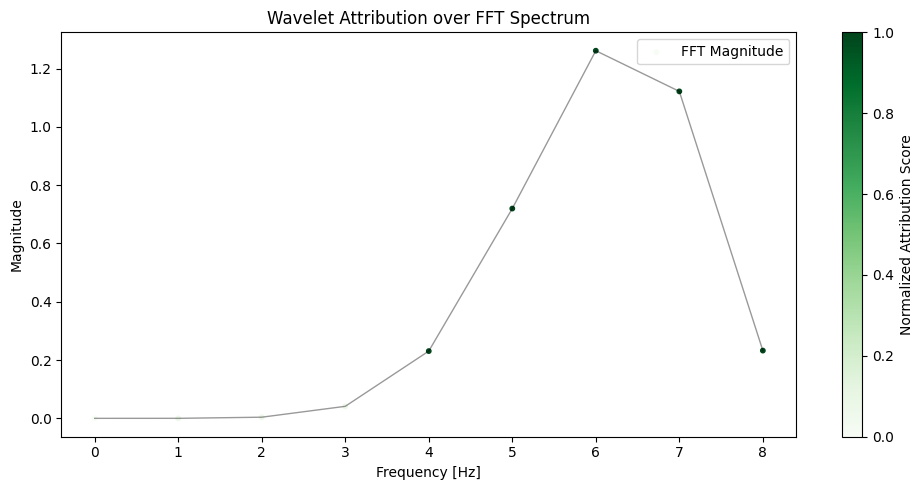

Prediction: 1, Label: 1


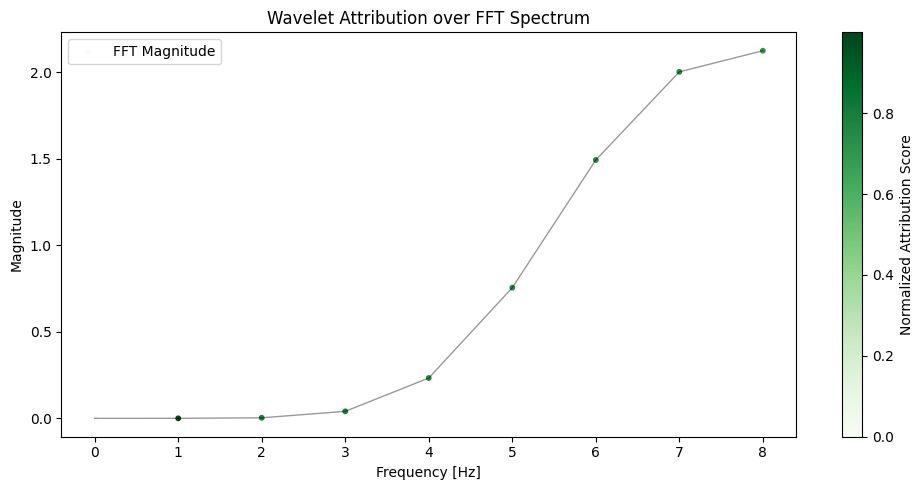

Prediction: 0, Label: 0


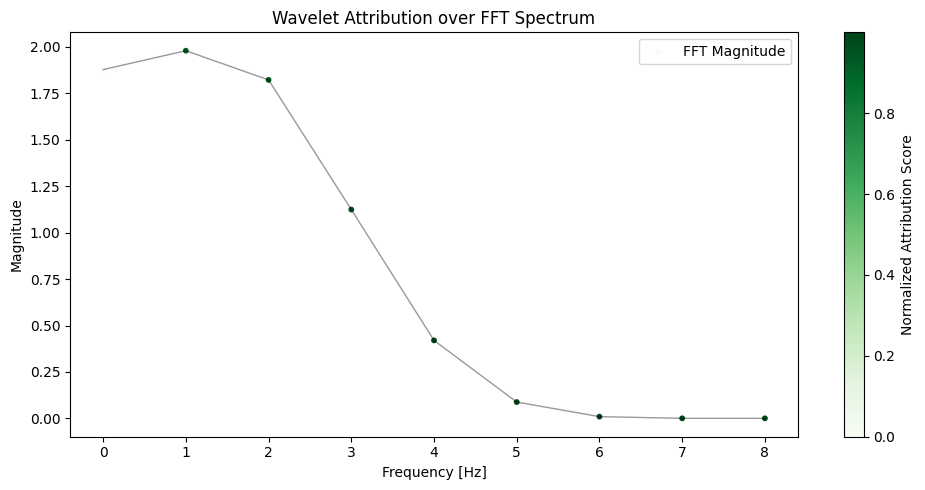

Prediction: 0, Label: 0


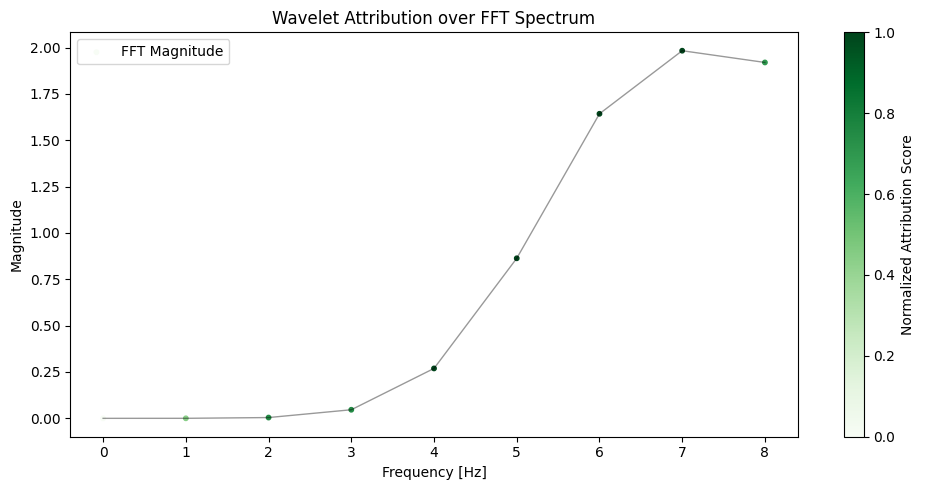

Prediction: 1, Label: 1


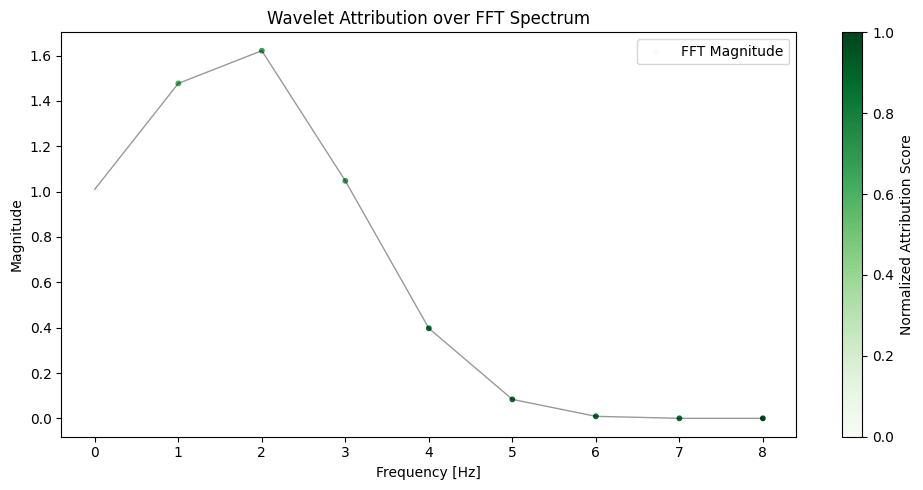

Prediction: 0, Label: 0


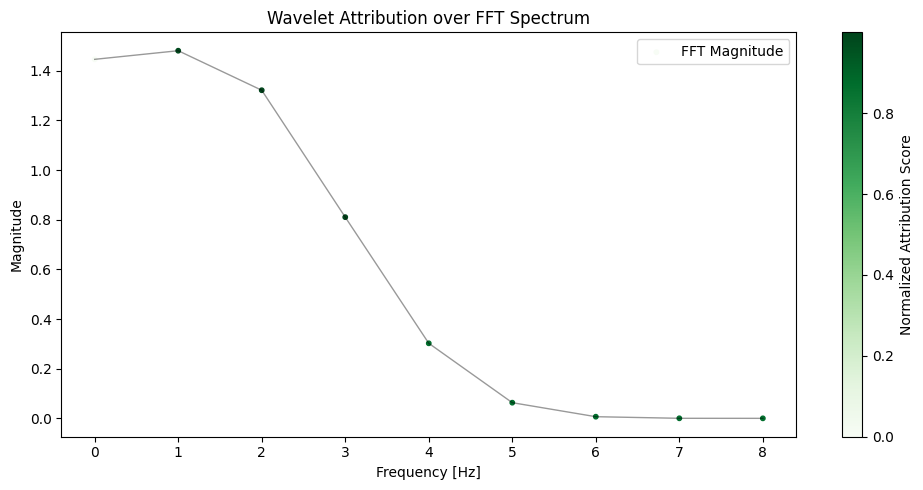

Prediction: 0, Label: 0


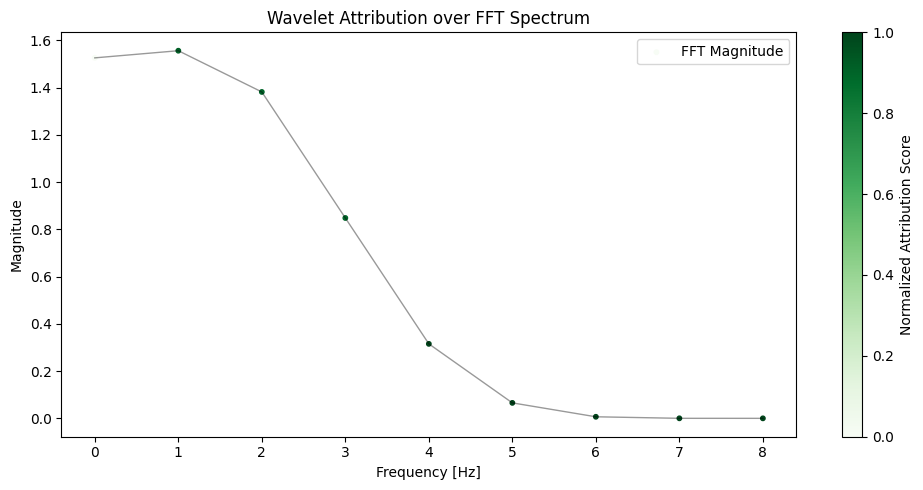

Prediction: 1, Label: 1


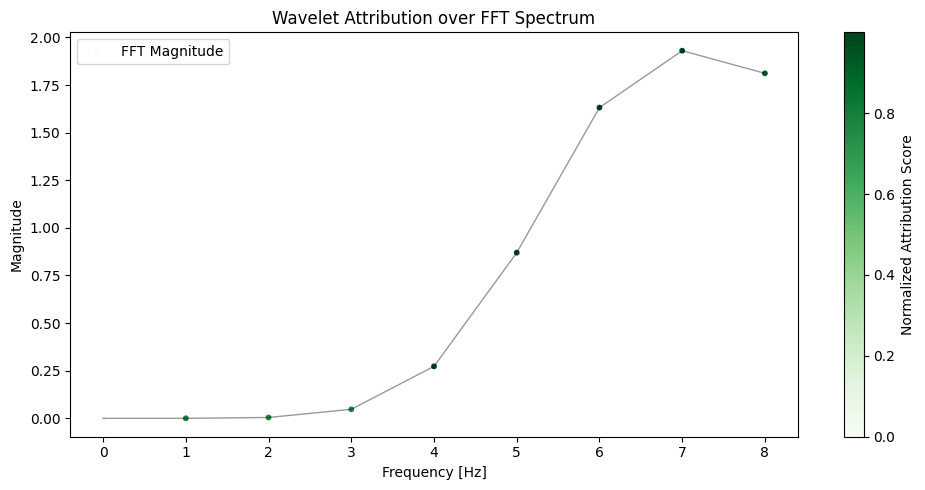

Prediction: 0, Label: 0


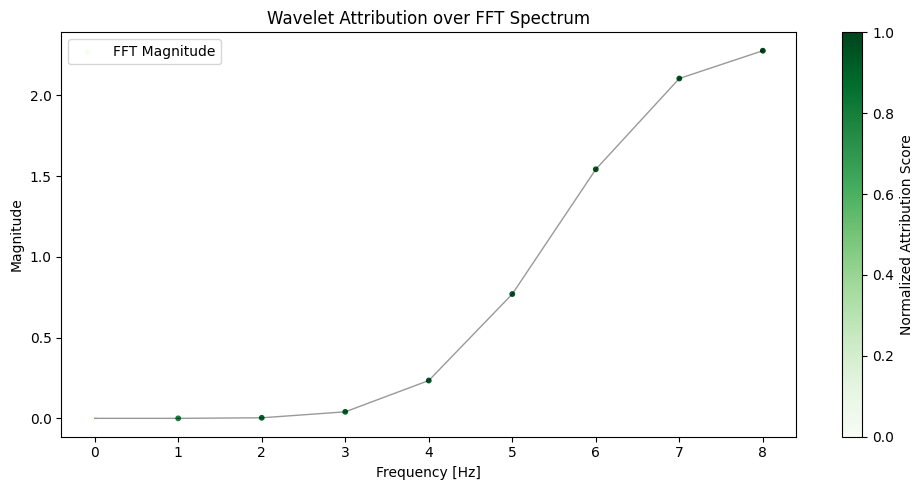

Prediction: 0, Label: 0


In [31]:
# plot the scores as a heatmap on the original signal
print(len(attributions['filtermasks_wavelet_db1_4_128']))
print(attributions['filtermasks_wavelet_db1_4_128'][0].shape)

# plot 5 samples
for i in range(1, 10):
    plot_freq_heatmap_fixed(x[i][0], attributions['filtermasks_wavelet_db1_4_128'][0][i], fs)

    # print the prediction and the label
    print(f"Prediction: {predictions[i].argmax()}, Label: {labels[i]}")

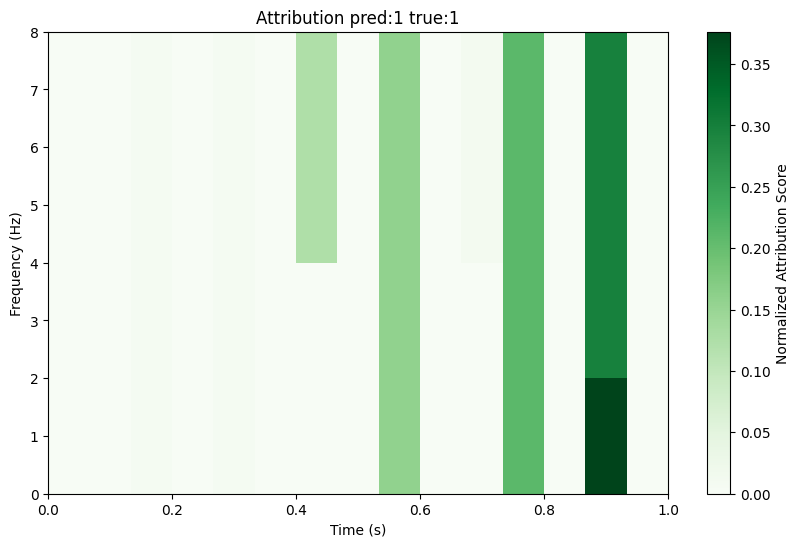

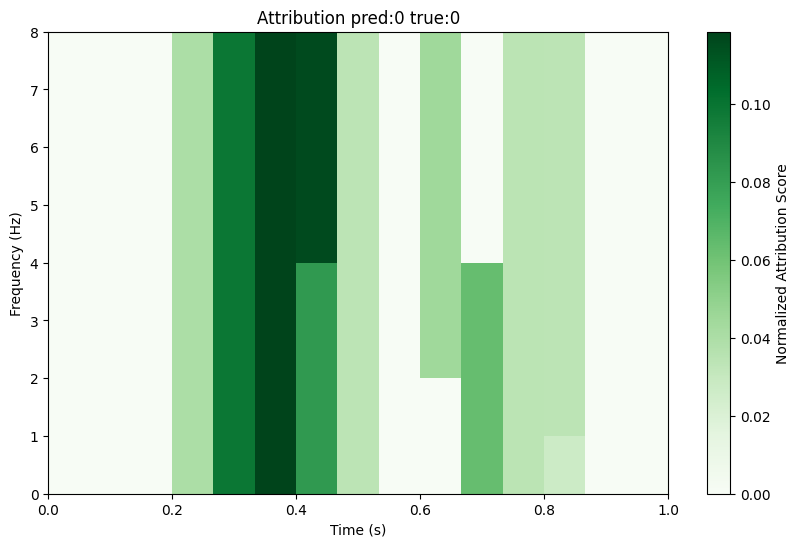

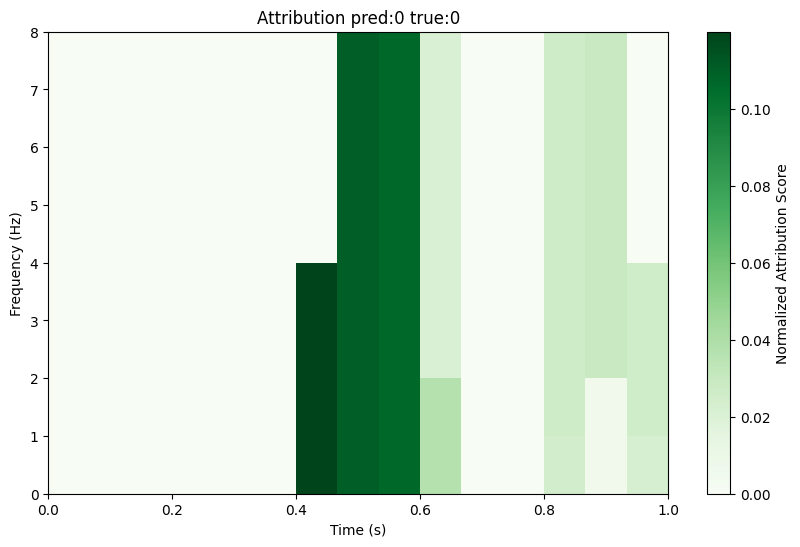

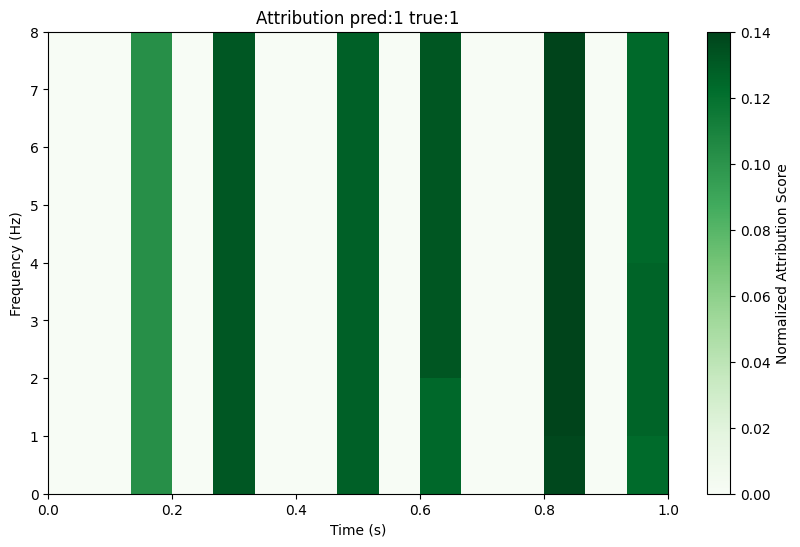

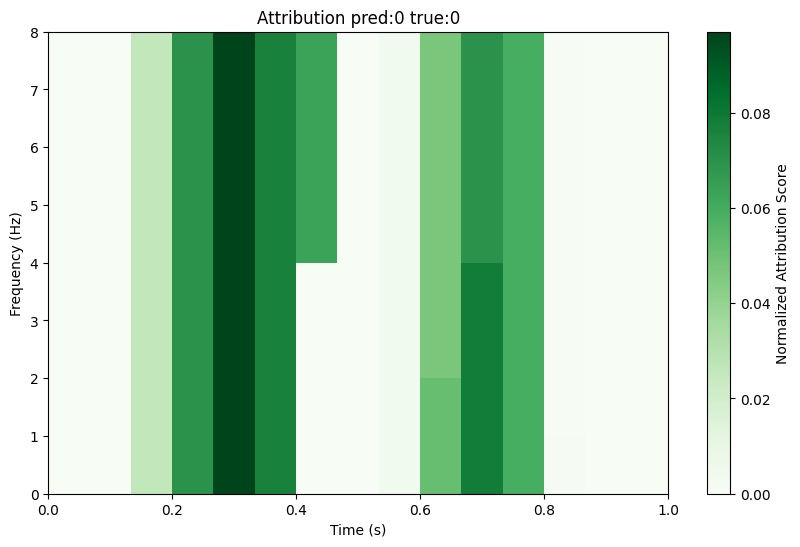

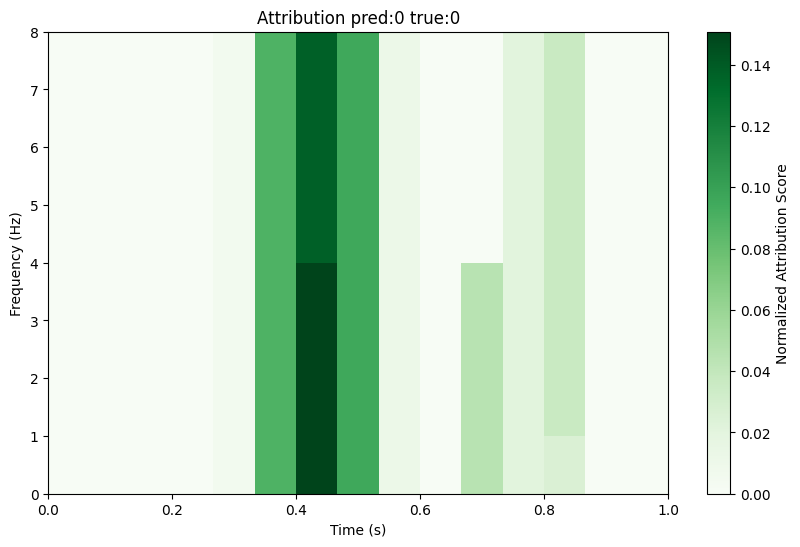

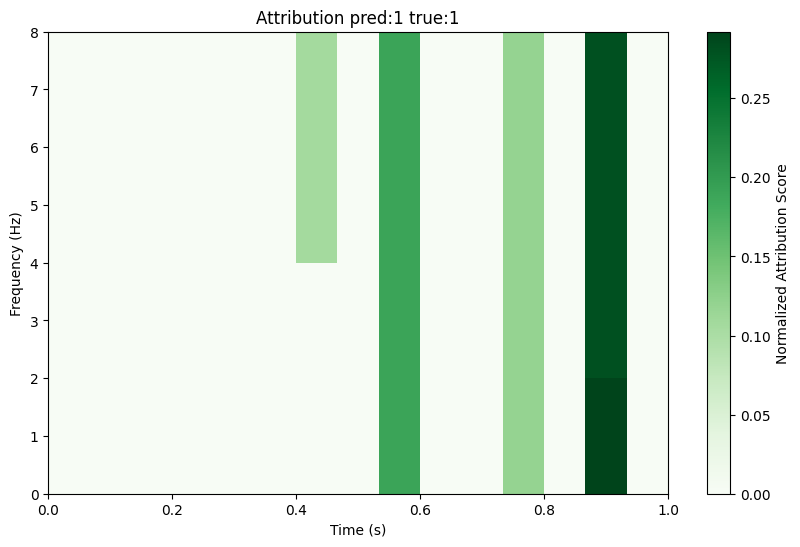

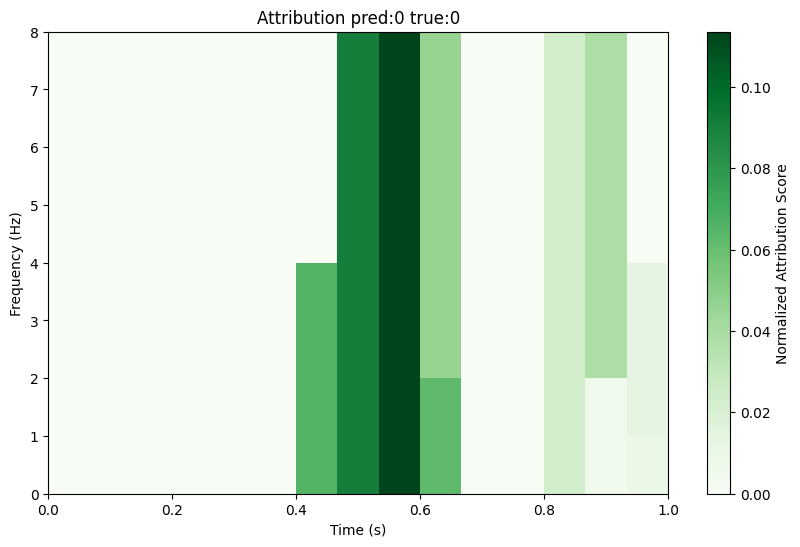

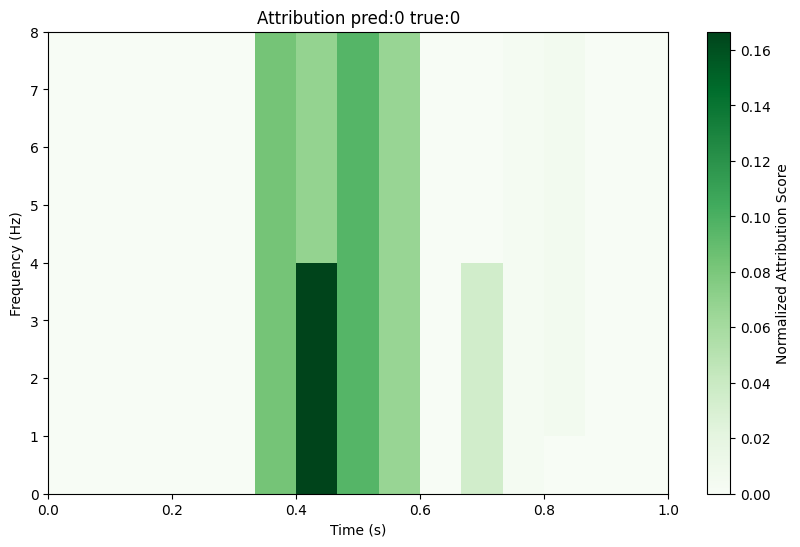

In [24]:
# plot the scores as a heatmap on the original signal
max_level = pywt.dwt_max_level(16, 'db1')

# plot 5 samples
for i in range(1, 10):
    plot_scaleogram_wav_heatmap(x[i][0], attributions['filtermasks_wavelet_db1_4_128'][0][i], prediction=attributions['predictions'][i].argmax(), label=attributions['labels'][i], fs=fs, level=max_level)


128
(16, 5)
(16, 5)


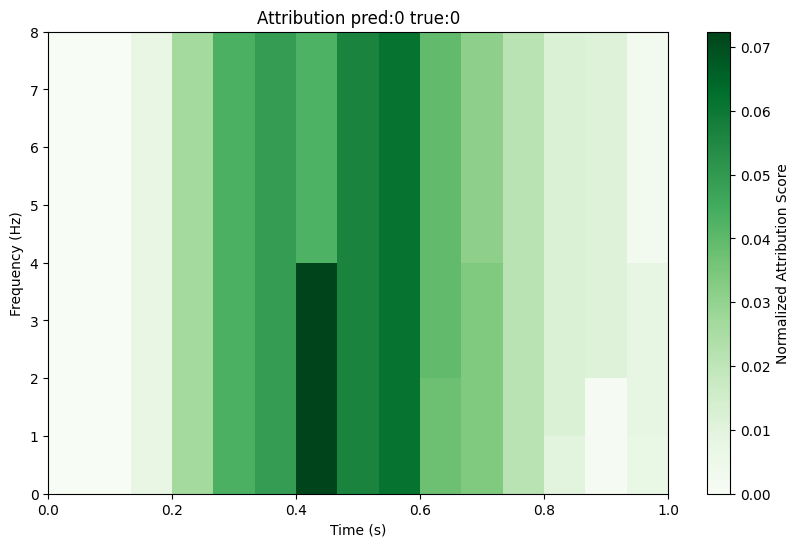

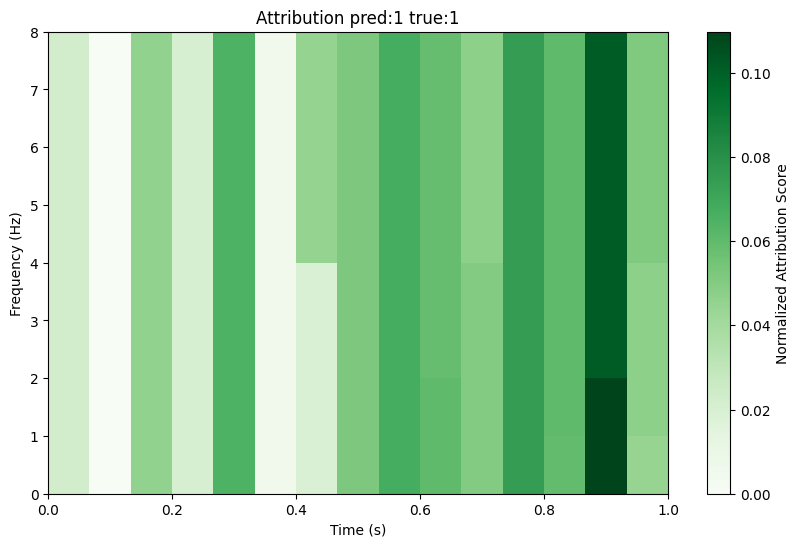

In [25]:
set_seed(42)

# compute an average of the attributions per class
# average the masks for each class
masks_0 = np.zeros_like(attributions[key_2][0][0])
masks_1 = np.zeros_like(attributions[key_2][0][0])

print(len(attributions[key_2][0]))

counts_0 = 0
counts_1 = 0

for i in range(len(attributions[key_2][0])):
    if attributions['labels'][i] == 0:
        masks_0 += attributions[key_2][0][i]
        counts_0 += 1
    else:
        masks_1 += attributions[key_2][0][i]
        counts_1 += 1
masks_0 /= counts_0
masks_1 /= counts_1
print(masks_0.shape)
print(masks_1.shape)

plot_scaleogram_wav_heatmap(x[0][0], masks_0, prediction=0, label=0, fs=fs, level=max_level)
plot_scaleogram_wav_heatmap(x[0][0], masks_1, prediction=1, label=1, fs=fs, level=max_level)


In [28]:
def compute_entropy_sample(attribution, epsilon=1e-10):
    abs_attr = np.abs(attribution)
    sum_attr = np.sum(abs_attr) + epsilon
    prob_dist = abs_attr / sum_attr
    entropy = -np.sum(prob_dist * np.log(prob_dist + epsilon))
    return entropy

In [29]:
# Compute the entropy-based complexity
complexity_scores = []

for i in range(len(attributions[key_])):
    attr = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    scores = []
    # print(attributions[key_][i].shape)
    for sample in attr:
        sample = sample.detach().cpu().numpy()
        c = compute_entropy_sample(sample)
        c = np.nan_to_num(c)
        scores.append(c)
    complexity_scores += scores

# compute the mean
mean_complexity = np.mean(complexity_scores)
print("Complexity Scores:")
print(mean_complexity)

Complexity Scores:
2.5151708


## Testing generating wavelet filter manually

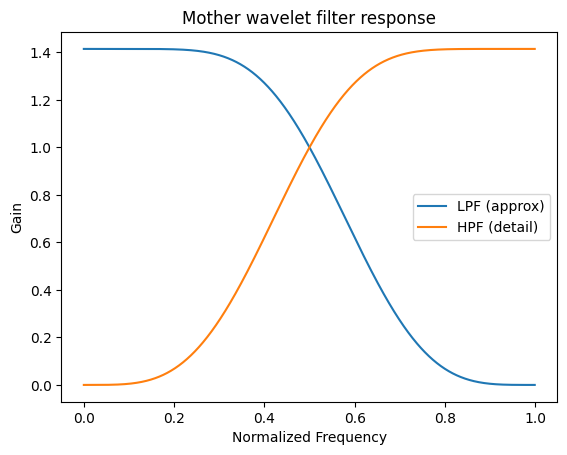

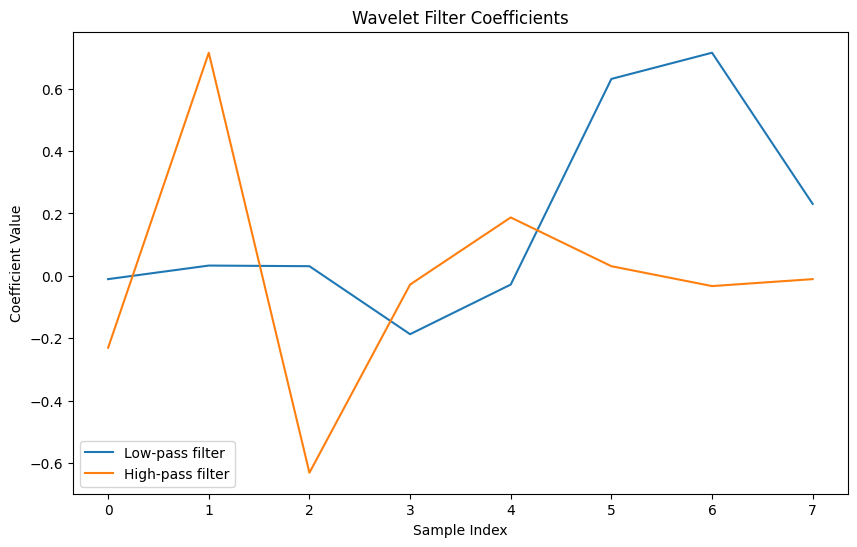

In [41]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

wavelet = pywt.Wavelet('db4')
dec_lo, dec_hi, _, _ = wavelet.filter_bank

# Frequency responses
w_lo, h_lo = freqz(dec_lo, worN=1024)
w_hi, h_hi = freqz(dec_hi, worN=1024)

plt.plot(w_lo / np.pi, abs(h_lo), label="LPF (approx)")
plt.plot(w_hi / np.pi, abs(h_hi), label="HPF (detail)")
plt.xlabel("Normalized Frequency")
plt.ylabel("Gain")
plt.legend()
plt.title("Mother wavelet filter response")
plt.show()


# plot the filter
plt.figure(figsize=(10, 6))
plt.plot(dec_lo, label='Low-pass filter')
plt.plot(dec_hi, label='High-pass filter')
plt.title('Wavelet Filter Coefficients')
plt.xlabel('Sample Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

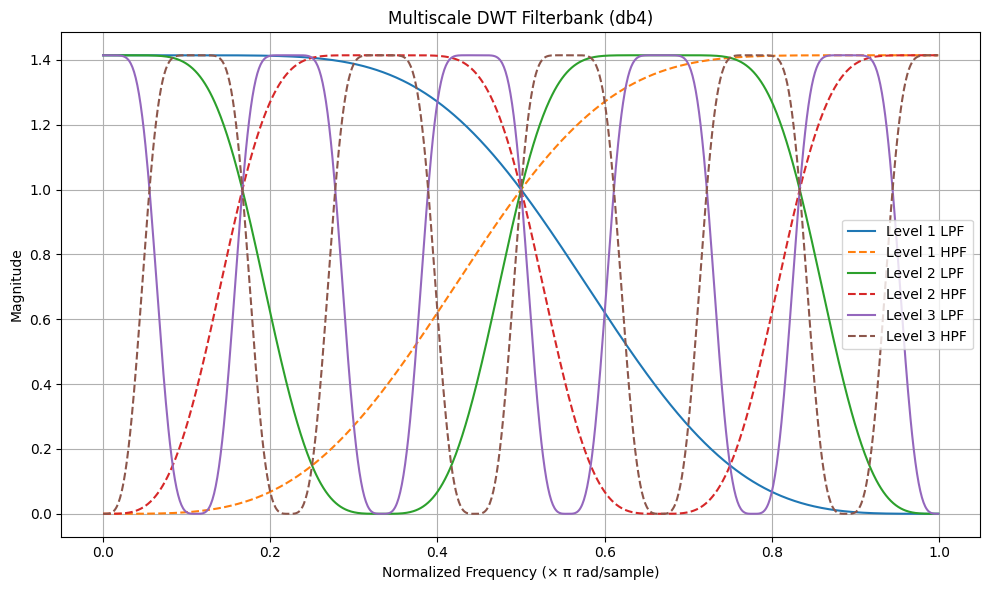

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Select wavelet and number of levels
wavelet = pywt.Wavelet('db4')
num_levels = 3  # Choose how many decomposition levels you want

# Get the decomposition low-pass and high-pass filter coefficients
dec_lo = wavelet.dec_lo  # Low-pass filter
dec_hi = wavelet.dec_hi  # High-pass filter

# Function to get frequency response for each level
def get_response(h, level):
    # Upsample by inserting 2**(level-1)-1 zeros between each coefficient
    h_up = np.copy(h)
    for _ in range(level - 1):
        h_up = np.insert(h_up, slice(1, None), 0)  # insert 0s between taps
        h_up = np.insert(h_up, slice(2, None, 2), 0)  # adjust for scale
    w, H = freqz(h_up, worN=1024)
    return w, np.abs(H)

# Plot the filter responses
plt.figure(figsize=(10, 6))

for level in range(1, num_levels + 1):
    w_lo, H_lo = get_response(dec_lo, level)
    w_hi, H_hi = get_response(dec_hi, level)

    plt.plot(w_lo / np.pi, H_lo, label=f'Level {level} LPF')
    plt.plot(w_hi / np.pi, H_hi, label=f'Level {level} HPF', linestyle='--')

plt.title('Multiscale DWT Filterbank (db4)')
plt.xlabel('Normalized Frequency (× π rad/sample)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


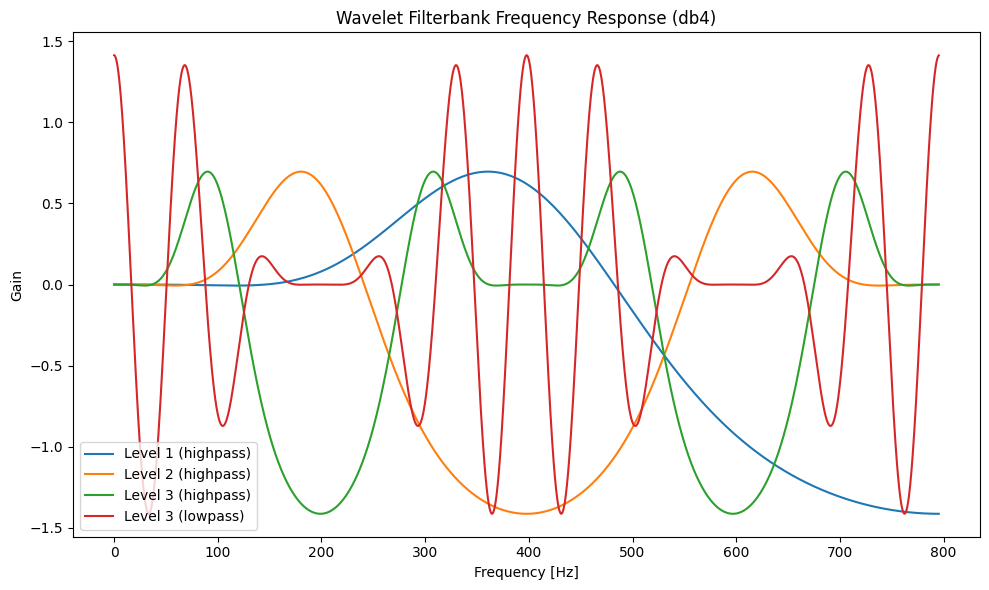

In [3]:
from src.attribution.wavelet.wavelet import WaveletFilterbank

# Create a WaveletFilterbank object
wavelet_filterbank = WaveletFilterbank(wavelet='db', w_len=4, level=3, fs=100)

# plot the filterbank
wavelet_filterbank.plot_filterbank()

Shape of x: (1000,)
4
(1000, 4)


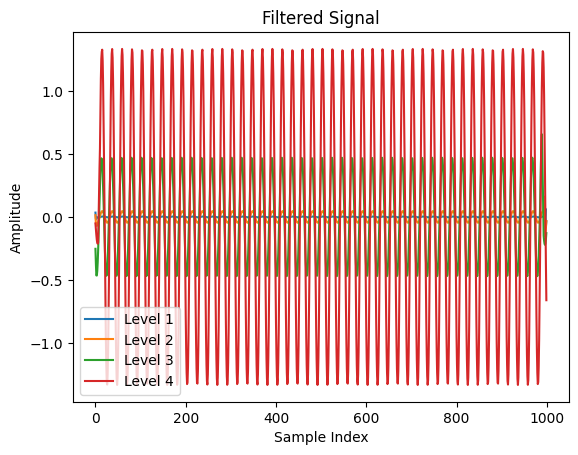

In [5]:
# genenrate a sinus wave with 10Hz with a sampling rate of 1000Hz
import numpy as np
import matplotlib.pyplot as plt

sin = np.sin(2 * np.pi * 45 * np.linspace(0, 1, 1000))

# Apply the filterbank to the signal
filtered_signal = wavelet_filterbank.apply_filterbank(sin)

print(filtered_signal.shape)

tmp = filtered_signal.T

# Plot the filtered signal
for i in range(len(tmp)):
    plt.plot(tmp[i], label=f'Level {i+1}')
plt.title('Filtered Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()




## Testing upsampling and downsampling

In [20]:
from src.utils.sampling import downsample_wavedec

# create a np array of ones with shape [128, 1, 16, 4]
x = np.ones((5, 1, 16, 4))

# change the position of the last two axes
x = np.moveaxis(x, -2, -1)

downsampled = []
for i in range(x.shape[0]):
    batch = []
    for j in range(x.shape[1]):
               batch.append(downsample_wavedec(x[i][j]))
    downsampled.append(batch)

print(len(downsampled))
print(len(downsampled[0]))
print(len(downsampled[0][0]))
print(len(downsampled[0][0][3]))




5
1
4
8


In [21]:
x = np.ones((5, 2, 16, 4))  # shape [batch=5, channel=1, time=16, features=4]
x = np.moveaxis(x, -2, -1)  # now shape: [5, 1, 4, 16]

# Initialize list of 4 levels (assuming 4 wavelet levels)
n_levels = 4
transposed = [[[] for _ in range(x.shape[0])] for _ in range(n_levels)]  # shape [4][5][channel=1]

for i in range(x.shape[0]):        # over batch
    for j in range(x.shape[1]):    # over channels
        coeffs = downsample_wavedec(x[i][j])  # returns [level_0, ..., level_3]
        for level_idx, level_coeff in enumerate(coeffs):
            transposed[level_idx][i].append(level_coeff)

print(len(transposed))
print(len(transposed[0]))
print(len(transposed[0][0]))
print(len(transposed[3][0][0]))

4
5
2
8
